In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, hinge_loss
from scipy.integrate import nquad
from scipy.stats import multivariate_normal


In [2]:
np.random.seed(seed=42)


In [3]:
def generate_data_2d(mean0, mean1, cov0, cov1, size=100):
    x1 = np.random.multivariate_normal(mean=mean0, cov=cov0, size=size)

    x2 = np.random.multivariate_normal(mean=mean1, cov=cov1, size=size)

    y = np.zeros(2 * size)
    y[size:] = 1
    x = np.concatenate((x1, x2), axis=0)

    return x, y


def generate_data_1d(mean0, mean1, sd0, sd1, size=100):
    x1 = (np.random.normal(size=size) * sd0) + mean0

    x2 = (np.random.normal(size=size) * sd1) + mean1

    y = np.zeros(2 * size)
    y[size:] = 1
    x = np.concatenate((x1, x2), axis=0).reshape(-1, 1)

    return x, y


In [4]:
def logloss(y, w, threshold=None):
    v = np.asarray((w * (2 * y - 1)))
    mask = v > 0
    v_p = v[mask]
    v_n = v[~mask]
    loss_v_p = np.log(1 + np.exp(-v_p)) / np.log(2)
    loss_v_n = (-v_n + np.log(1 + np.exp(v_n))) / np.log(2)
    loss = np.concatenate((loss_v_p, loss_v_n))

    if threshold:
        max_value = np.abs(logloss(1, threshold))
        loss[loss > max_value] = max_value
        return loss.mean() / max_value

    return loss.mean()


In [5]:
def hingeloss(y, w, threshold=None):
    loss = np.asarray(1 - w * (2 * y - 1))
    loss[loss < 0] = 0

    if threshold:
        max_value = np.abs(hingeloss(1, threshold))
        loss[loss > max_value] = max_value
        return loss.mean() / max_value

    return loss.mean()


In [6]:
def risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    loss,
    print_result=False,
    calc_true_risk=True,
    threshold=None,
):
    if x_train.ndim == 1:
        d = 1
    else:
        d = x_train.shape[1]

    model.fit(x_train, y_test)

    emp_risk = loss(y_test, model.decision_function(x_test))

    bounds = []
    for _ in range(d):
        bounds.append([np.NINF, np.PINF])

    def loss_pdf(*x):
        x_arr_2d = np.asarray(x).reshape(1, -1)
        x_arr_1d = np.asarray(x)
        return (1 / 2) * (
            (
                loss(0, model.decision_function(x_arr_2d), threshold)
                * multivariate_normal.pdf(x_arr_1d, mean=mean0, cov=cov0)
            )
            + (
                loss(1, model.decision_function(x_arr_2d), threshold)
                * multivariate_normal.pdf(x_arr_1d, mean=mean1, cov=cov1)
            )
        )

    if calc_true_risk:
        true_risk = nquad(loss_pdf, bounds)[0]
        gen_err = true_risk - emp_risk

    if print_result:
        print("empirical risk {}".format(emp_risk))
        if calc_true_risk:
            print("true risk {}".format(true_risk))
            print("generalization error {}".format(gen_err))

    if calc_true_risk:
        return emp_risk, true_risk, gen_err
    else:
        return emp_risk


In [7]:
def gen_err_per_train_size(
    model, mean0, mean1, cov0, cov1, start, end, num, loss, generator, threshold=None
):
    sizes = np.linspace(start, end, num)
    gen_errs = []
    true_risk = None
    for size in sizes:
        x_train, y_train = generator(mean0, mean1, cov0, cov1, size=int(size))
        x_test, y_test = generator(mean0, mean1, cov0, cov1, size=int(size))
        if not true_risk:
            _, true_risk, gen_err = risk_report(
                model,
                mean0,
                mean1,
                cov0,
                cov1,
                x_train,
                y_train,
                x_test,
                y_test,
                loss,
                print_result=False,
                calc_true_risk=True,
                threshold=threshold,
            )
        else:
            emp_risk = risk_report(
                model,
                mean0,
                mean1,
                cov0,
                cov1,
                x_train,
                y_train,
                x_test,
                y_test,
                loss,
                print_result=False,
                calc_true_risk=False,
                threshold=threshold,
            )
            gen_err = true_risk - emp_risk
        gen_errs.append(gen_err)
    return sizes, gen_errs


### 1-D Case

In [8]:
mean0 = 1
cov0 = 1.5
mean1 = 3
cov1 = 1.5


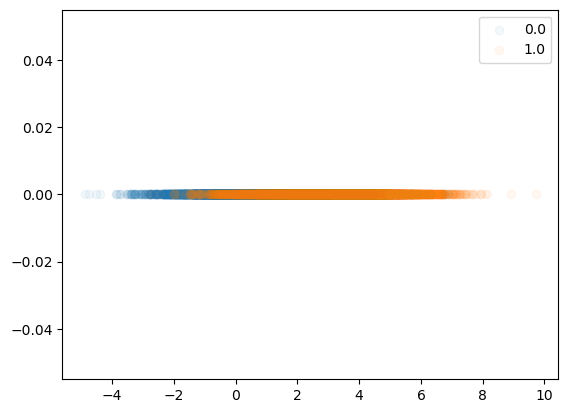

In [9]:
x_train, y_train = generate_data_1d(mean0, mean1, cov0, cov1, size=10000)
for label in np.unique(y_train):
    idx = np.where(y_train == label)
    plt.scatter(x_train[idx], np.zeros(x_train[idx].shape[0]), alpha=0.05, label=label)
plt.legend()


In [10]:
x_test, y_test = generate_data_1d(mean0, mean1, cov0, cov1, size=10000)


In [11]:
results_gen_err = {"svc": {"log": 0, "hinge": 0}, "lr": {"log": 0, "hinge": 0}}
model = LinearSVC(max_iter=10000)

print("# linear svc:")
print("---")
print("## using log loss:")
_, _, results_gen_err["svc"]["log"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    logloss,
    print_result=True,
)
print("## using hinge loss:")
_, _, results_gen_err["svc"]["hinge"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    hingeloss,
    print_result=True,
)

print("------------------------------")
model = LogisticRegression(max_iter=10000)

print("# logistic regression:")
print("---")
print("## using log loss:")
_, _, results_gen_err["lr"]["log"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    logloss,
    print_result=True,
)
print("## using hinge loss:")
_, _, results_gen_err["lr"]["hinge"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    hingeloss,
    print_result=True,
)


# linear svc:
---
## using log loss:
empirical risk 0.8195240953740638
true risk 0.8060618301863756
generalization error -0.013462265187688227
## using hinge loss:
empirical risk 0.6827766642279006
true risk 0.671446038665045
generalization error -0.011330625562855579
------------------------------
# logistic regression:
---
## using log loss:
empirical risk 0.7340441385774567
true risk 0.6603923407806627
generalization error -0.07365179779679398
## using hinge loss:
empirical risk 0.5884520670685235
true risk 0.4916870761453146
generalization error -0.0967649909232089


<AxesSubplot: >

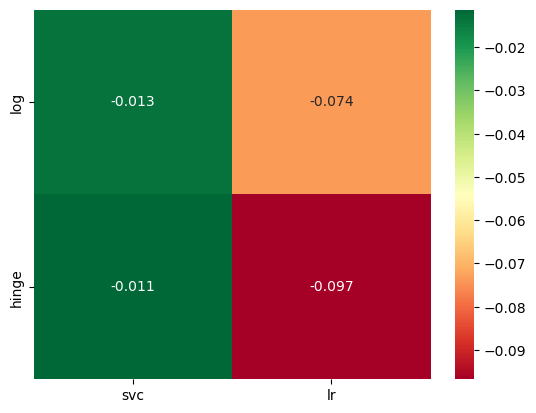

In [12]:
sns.heatmap(pd.DataFrame.from_dict(results_gen_err), cmap="RdYlGn", annot=True)


Text(0.5, 1.0, 'Generalization error per training set size (logistic regression) not normalized')

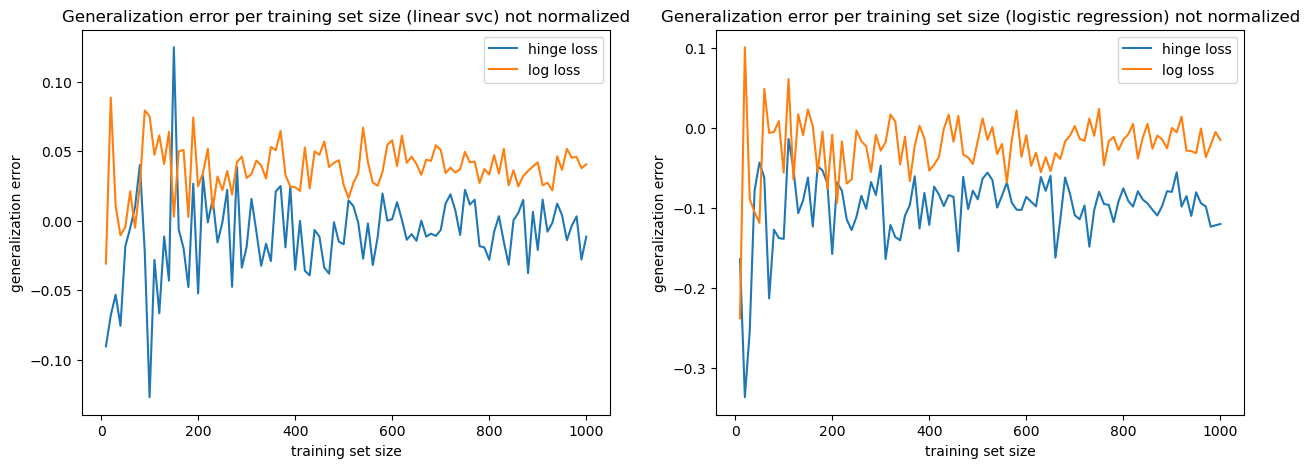

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_1d,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_1d,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (linear svc) not normalized")

plt.subplot(1, 2, 2)
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_1d,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_1d,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title(
    "Generalization error per training set size (logistic regression) not normalized"
)


Text(0.5, 1.0, 'Generalization error per training set size (logistic regression) normalized')

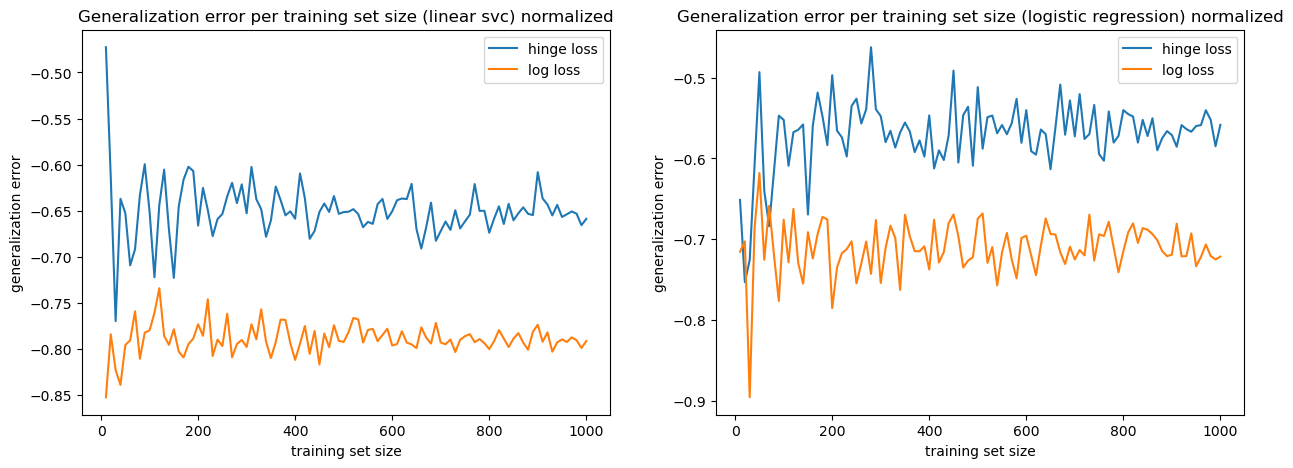

In [14]:
threshold = -20
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_1d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_1d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (linear svc) normalized")

plt.subplot(1, 2, 2)
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_1d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_1d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (logistic regression) normalized")


### 2-D Case

In [15]:
mean0 = np.array([3, 1])
cov0 = np.array([[1.5, 0.5], [0.5, 1.5]])
mean1 = np.array([1, 3])
cov1 = np.array([[1.5, 0.5], [0.5, 1.5]])


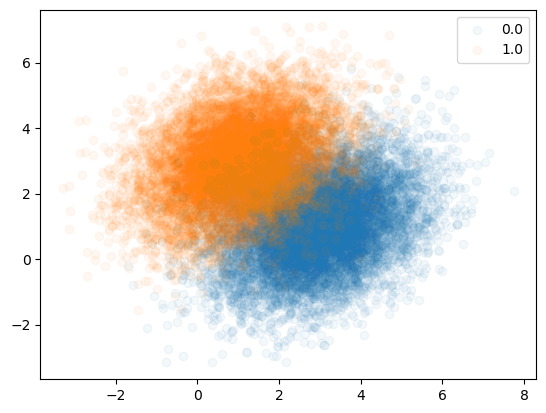

In [16]:
x_train, y_train = generate_data_2d(mean0, mean1, cov0, cov1, size=10000)

for label in np.unique(y_train):
    idx = np.where(y_train == label)
    plt.scatter(x_train[idx, 0], x_train[idx, 1], alpha=0.05, label=label)
plt.legend()


In [17]:
x_test, y_test = generate_data_2d(mean0, mean1, cov0, cov1, size=10000)


In [18]:
results_gen_err = {"svc": {"log": 0, "hinge": 0}, "lr": {"log": 0, "hinge": 0}}
model = LinearSVC(max_iter=10000)

print("# linear svc:")
print("---")
print("## using log loss:")
_, _, results_gen_err["svc"]["log"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    logloss,
    print_result=True,
)
print("## using hinge loss:")
_, _, results_gen_err["svc"]["hinge"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    hingeloss,
    print_result=True,
)

print("------------------------------")
model = LogisticRegression(max_iter=10000)

print("# logistic regression:")
print("---")
print("## using log loss:")
_, _, results_gen_err["lr"]["log"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    logloss,
    print_result=True,
)
print("## using hinge loss:")
_, _, results_gen_err["lr"]["hinge"] = risk_report(
    model,
    mean0,
    mean1,
    cov0,
    cov1,
    x_train,
    y_train,
    x_test,
    y_test,
    hingeloss,
    print_result=True,
)


# linear svc:
---
## using log loss:
empirical risk 0.46428728950278303
true risk 0.4624487286571163
generalization error -0.001838560845666748
## using hinge loss:
empirical risk 0.24593432387648786
true risk 0.24338216953242248
generalization error -0.002552154344065388
------------------------------
# logistic regression:
---
## using log loss:
empirical risk 0.28318295610239236
true risk 0.2787274434280478
generalization error -0.004455512674344575
## using hinge loss:
empirical risk 0.2131053178371676
true risk 0.2099052892932304
generalization error -0.0032000285439371945


<AxesSubplot: >

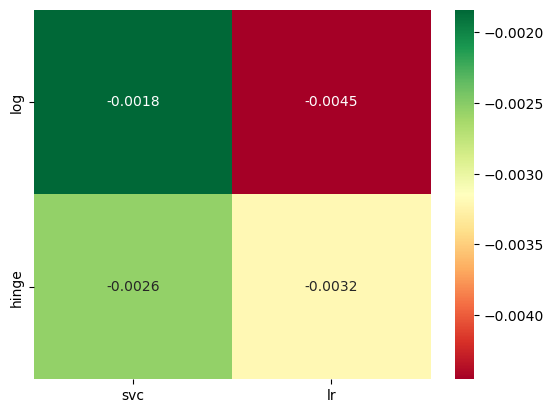

In [19]:
sns.heatmap(pd.DataFrame.from_dict(results_gen_err), cmap="RdYlGn", annot=True)


Text(0.5, 1.0, 'Generalization error per training set size (logistic regression) not normalized')

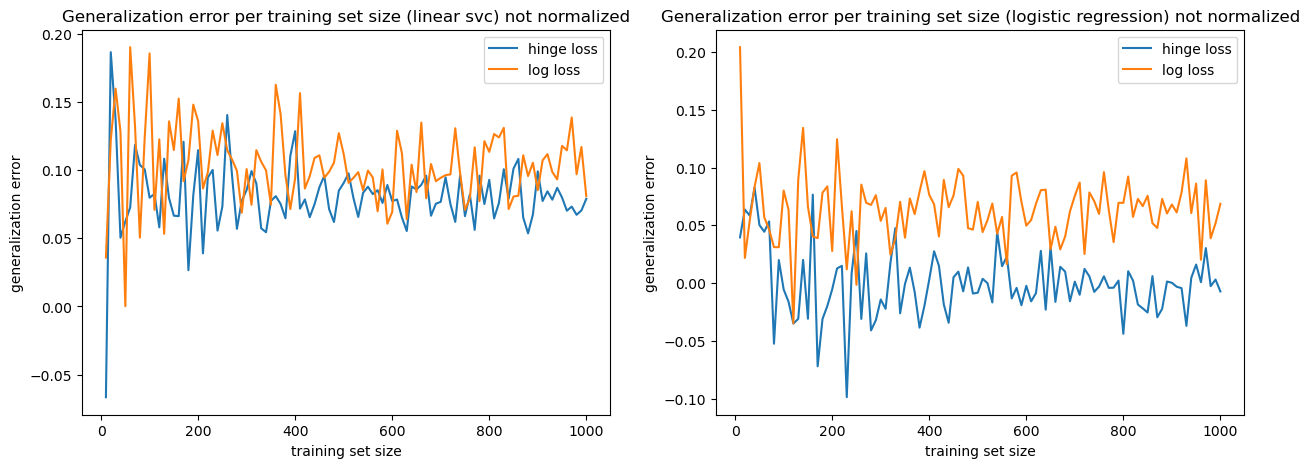

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_2d,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_2d,
    1,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (linear svc) not normalized")

plt.subplot(1, 2, 2)
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_2d,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_2d,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()

plt.title(
    "Generalization error per training set size (logistic regression) not normalized"
)


Text(0.5, 1.0, 'Generalization error per training set size (logistic regression) normalized')

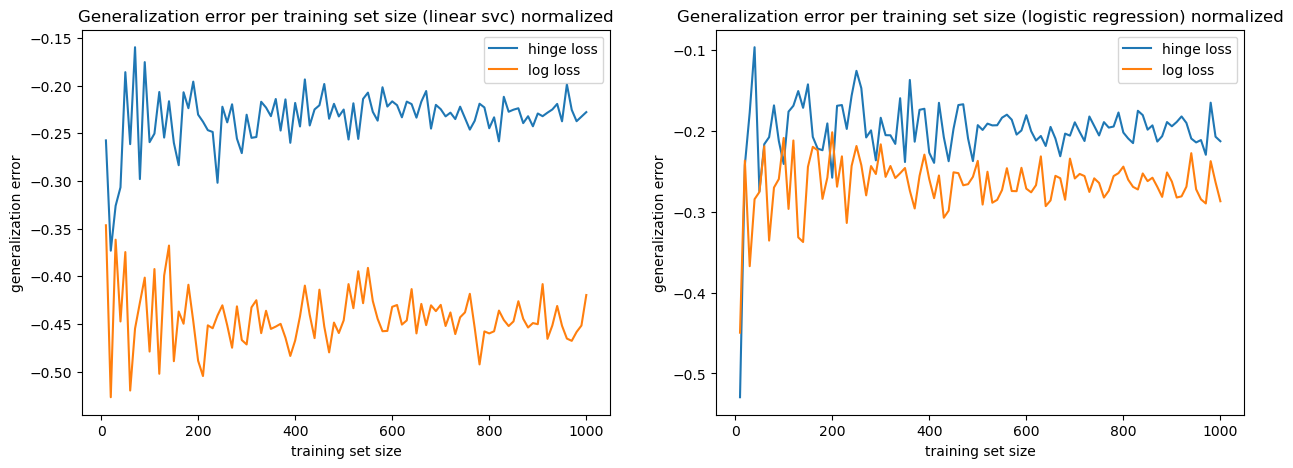

In [21]:
1 threshold = -20
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_2d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LinearSVC(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_2d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (linear svc) normalized")

plt.subplot(1, 2, 2)
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    hingeloss,
    generate_data_2d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="hinge loss")
sizes, gen_errs = gen_err_per_train_size(
    LogisticRegression(max_iter=10000),
    mean0,
    mean1,
    cov0,
    cov1,
    10,
    1_000,
    100,
    logloss,
    generate_data_2d,
    threshold=threshold,
)
plt.plot(sizes, gen_errs, label="log loss")
plt.xlabel("training set size")
plt.ylabel("generalization error")
plt.legend()
plt.title("Generalization error per training set size (logistic regression) normalized")


**We can deduce that:**
* **The size of the dataset used to estimate the empirical risk does not matter as long as it is big enough (depending on the problem).**
* **Losses that are smaller asymptotically, have smaller generalization error**.
* **Generalization error calculated using hinge loss is lower than that of logistic loss since they have different asymptotic growth. But when the maximum loss value is thresholded and normalized by the maximum value, we observe the opposite trend, where generalization error of logistic loss is lower.**